In [2]:
import os
import sys
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd

# Ensure we can import data_handling
sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader

data_dir = Path("measurements")
print(f"Data resides in: {data_dir.resolve()}")

Data resides in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_consolidate/xxz_ring_16/measurements


In [3]:
class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.cond_dim = cond_dim
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))

        self.initialize_weights(w_std=0.1)

    def initialize_weights(self, w_mean: float = 0.0, w_std: float = 0.1, bias_val: float = 0.0):
        nn.init.normal_(self.W, mean=w_mean, std=w_std)
        nn.init.constant_(self.b, bias_val)
        nn.init.constant_(self.c, bias_val)

    @staticmethod
    def _free_energy(v: torch.Tensor, W: torch.Tensor, b: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        v = v.to(dtype=W.dtype, device=W.device)
        # b is expected to be (B, N) or (1, N). v is (B, N).
        # Broadcasting handles term1 calculation.
        term1 = -(v * b).sum(dim=-1)
        term2 = F.softplus(v @ W + c).sum(dim=-1)
        return term1 - term2

    def _compute_effective_biases(self, cond: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        # Unsqueeze to ensure we can broadcast over hidden/visible dim if cond is (B, D)
        # b shape: (N,) -> (1, N). Result matches cond batch dim.
        b_mod = self.b
        c_mod = self.c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, T: float, rng: torch.Generator):
        p_h = torch.sigmoid((v @ self.W + c_mod) / T)
        h = torch.bernoulli(p_h, generator=rng)
        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / T)
        v_next = torch.bernoulli(p_v, generator=rng)
        return v_next

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        """
        Computes log(P*(v|cond)).
        IMPORTANT: 'cond' must be broadcastable against 'v'.
        If v is (B_v, N) and cond is (1, D), it works.
        If v is (B_v, N) and cond is (B_cond, D), B_v must equal B_cond.
        """
        b_mod, c_mod = self._compute_effective_biases(cond)
        fe = self._free_energy(v, self.W, b_mod, c_mod)
        return -0.5 * fe / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        values, _, cond = batch
        v_data = values.to(dtype=self.W.dtype, device=self.W.device)

        rng = aux_vars.get("rng", torch.Generator(device="cpu"))
        l2_strength = float(aux_vars.get("l2_strength", 0.0))
        noise_frac = float(aux_vars.get("noise_frac", 0.05))

        cond = cond.to(v_data.device, dtype=v_data.dtype)
        b_mod, c_mod = self._compute_effective_biases(cond)
        l2_reg = (self.b.unsqueeze(0) - b_mod).pow(2).sum() + (self.c.unsqueeze(0) - c_mod).pow(2).sum()

        v_model = v_data.clone()
        batch_size = v_data.shape[0]
        n_noise = int(batch_size * noise_frac)
        if n_noise > 0:
            v_model[:n_noise] = torch.bernoulli(torch.full_like(v_model[:n_noise], 0.5), generator=rng)

        for _ in range(self.k):
            v_model = self._gibbs_step(v_model, b_mod, c_mod, self.T, rng)

        v_model = v_model.detach()

        # Stats
        n_flips = (v_data != v_model).float().sum()
        flip_rate = n_flips / v_data.numel()
        max_bias = torch.max(torch.abs(b_mod)).detach()

        fe_data = self._free_energy(v_data, self.W, b_mod, c_mod)
        fe_model = self._free_energy(v_model, self.W, b_mod, c_mod)
        fe_diff = fe_data - fe_model
        loss = fe_diff.mean() + l2_strength * l2_reg

        return loss, {
            "flip_rate": flip_rate,
            "max_bias": max_bias
        }

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, T_schedule: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        B = cond.shape[0]
        if cond.dim() == 1: cond = cond.view(-1, self.cond_dim)
        if T_schedule.dim() == 0: T_schedule = T_schedule.view(1)
        cond = cond.to(next(self.parameters()).device, dtype=torch.float32)
        b_mod, c_mod = self._compute_effective_biases(cond)

        probs = torch.full((B, self.num_visible), 0.5, device=cond.device, dtype=torch.float32)
        v = torch.bernoulli(probs, generator=rng)

        for i in range(int(T_schedule.shape[0])):
            v = self._gibbs_step(v, b_mod, c_mod, float(T_schedule[i]), rng)
        return v

In [4]:
def compute_renyi_entropy_from_samples(
        samples: torch.Tensor,
        subsystem_size: int,
        score_fn: Callable[[torch.Tensor], torch.Tensor]
) -> float:
    """
    Computes S2 = -ln(<Swap>) using the replica trick.
    """
    n_samples = samples.shape[0]
    half = n_samples // 2
    if half == 0:
        return 0.0

    batch1 = samples[:half]
    batch2 = samples[half:2 * half]

    # Subsystem B indices: from l to end
    idx_B = torch.arange(subsystem_size, samples.shape[1], device=samples.device)

    # Calculate log amplitudes (log_psi)
    # The score_fn is expected to return log(psi) which is -0.5 * Energy
    log_psi_1 = score_fn(batch1)
    log_psi_2 = score_fn(batch2)

    # Swap subsystem B between replicas
    batch1_swap = batch1.clone()
    batch1_swap[:, idx_B] = batch2[:, idx_B]
    batch2_swap = batch2.clone()
    batch2_swap[:, idx_B] = batch1[:, idx_B]

    log_psi_1_swap = score_fn(batch1_swap)
    log_psi_2_swap = score_fn(batch2_swap)

    # Ratio = (Psi(v1')Psi(v2')) / (Psi(v1)Psi(v2))
    log_ratio = (log_psi_1_swap + log_psi_2_swap) - (log_psi_1 + log_psi_2)
    ratios = torch.exp(log_ratio)

    swap_expectation = ratios.mean().item()

    if swap_expectation <= 1e-12:
        return 0.0

    return -math.log(swap_expectation)


def monitor_entropy(model, device, chain_len, n_samples=2000):
    model.eval()

    # 1. Condition for Generation: Needs to be size (n_samples, 1)
    # We choose Delta=1.0 (Heisenberg) for monitoring
    delta_val = 1.0
    cond_gen = torch.tensor([[delta_val]], device=device).expand(n_samples, -1)

    # 2. Condition for Scoring: Needs to be size (1, 1)
    # This allows it to broadcast against the split batches (size n_samples/2)
    # inside compute_renyi_entropy_from_samples.
    cond_score = torch.tensor([[delta_val]], device=device)

    T_schedule = torch.tensor([1.0] * 20, device=device)
    rng = torch.Generator(device=device)

    # Generate samples
    samples = model.generate(cond_gen, T_schedule, rng)

    # Define scorer with broadcastable condition
    scorer = lambda v: model.log_score(v, cond_score)

    # Compute S2 for half chain
    half_chain = chain_len // 2
    s2 = compute_renyi_entropy_from_samples(samples, half_chain, scorer)

    model.train()
    return s2

In [5]:
def train_step(model: nn.Module, optimizer: torch.optim.Optimizer,
               batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
    optimizer.zero_grad(set_to_none=True)
    loss, aux = model(batch, aux_vars)
    loss.backward()
    optimizer.step()
    return loss.detach(), aux

def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None: center_step = steps / 2.0
    def curve_fn(step: int) -> float:
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center_step))))
    return curve_fn

def train(model: nn.Module, optimizer: torch.optim.Optimizer, loader, num_epochs: int, rng: torch.Generator,
          l2_strength: float, noise_frac: float, lr_schedule_fn: Callable[[int], float],
          chain_length: int):

    metrics: Dict[int, Any] = {}
    global_step = 0
    device = next(model.parameters()).device

    header = f"{'Epoch':<6} | {'Loss':<9} | {'Flips':<6} | {'MaxBias':<7} | {'LR':<8} | {'S2(L/2)':<8}"
    print(header)
    print("-" * len(header))

    for epoch in range(num_epochs):
        tot_loss = 0.0
        avg_flip = 0.0
        max_bias_epoch = 0.0

        for batch in loader:
            lr = float(lr_schedule_fn(global_step))
            for g in optimizer.param_groups:
                g["lr"] = lr

            aux_vars = { "rng": rng, "l2_strength": l2_strength, "noise_frac": noise_frac }
            loss, aux_out = train_step(model, optimizer, batch, aux_vars)

            tot_loss += float(loss)
            avg_flip += float(aux_out.get("flip_rate", 0.0))
            max_bias_epoch = max(max_bias_epoch, float(aux_out.get("max_bias", 0.0)))

            global_step += 1

        avg_loss = tot_loss / len(loader)
        lr_epoch = float(lr_schedule_fn(global_step))
        avg_flip_pct = (avg_flip / len(loader)) * 100.0

        # Monitor Entropy using the fixed logic
        s2_curr = monitor_entropy(model, device, chain_length)

        metrics[epoch] = dict(loss=avg_loss, lr=lr_epoch, s2=s2_curr)

        print(f"{epoch + 1:<6} | {avg_loss:+.4f}   | "
              f"{avg_flip_pct:5.2f}% | {max_bias_epoch:5.2f}   | "
              f"{lr_epoch:.5f}  | {s2_curr:.4f}")

    return model, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2.0
    def curve_fn(step: int) -> float:
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center_step))))
    return curve_fn

In [6]:
# DATA LOADING

CHAIN_LENGTH = 16
FILE_SAMPLES = 5_000_000
TRAIN_SAMPLES = 100_000

# Training support deltas
delta_support = [1.00]

file_names = [f"xxz_{CHAIN_LENGTH}_delta{d:.2f}_{FILE_SAMPLES}.npz" for d in delta_support]
file_paths = [data_dir / fn for fn in file_names]
samples_per_file = [TRAIN_SAMPLES] * len(file_paths)

print(f"System Size       : {CHAIN_LENGTH} spins (1D Chain)")
print(f"Training Samples  : {TRAIN_SAMPLES} per file")
print(f"Support Deltas    : {delta_support}")

# Basic check
missing = [f.name for f in file_paths if not f.exists()]
if missing:
    print(f"WARNING: Missing files: {missing}")
else:
    print("All files found.")

ds = MeasurementDataset(file_paths, load_fn=load_measurements_npz,
                        system_param_keys=["delta"], samples_per_file=samples_per_file)

print(f"Samples Shape     : {tuple(ds.values.shape)}")
print(f"Conditions Shape  : {tuple(ds.system_params.shape)}")

System Size       : 16 spins (1D Chain)
Training Samples  : 100000 per file
Support Deltas    : [1.0]
All files found.
Samples Shape     : (100000, 16)
Conditions Shape  : (100000, 1)


In [14]:
batch_size        = 1024
num_visible       = ds.num_qubits
num_hidden        = 32
conditioner_width = 64

num_epochs        = 10
k_steps           = 100
init_lr           = 1e-2
final_lr          = 1e-3
l2_strength       = 1e-5
noise_frac        = 1.0

SEED = 42
torch.manual_seed(SEED)
rng = torch.Generator().manual_seed(SEED)

loader = MeasurementLoader(dataset=ds, batch_size=batch_size, shuffle=True, drop_last=False, rng=rng)

model = ConditionalRBM(num_visible=num_visible, num_hidden=num_hidden, cond_dim=ds.system_params.shape[1],
                       conditioner_width=conditioner_width, k=k_steps, T=1.0)
model.initialize_weights(w_mean=0.0, w_std=0.1, bias_val=0.0)

optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005)

model, metrics = train(model=model, optimizer=optimizer, loader=loader, num_epochs=num_epochs,
                       rng=rng, l2_strength=l2_strength, noise_frac=noise_frac,
                       lr_schedule_fn=lr_schedule_fn, chain_length=CHAIN_LENGTH)

Epoch  | Loss      | Flips  | MaxBias | LR       | S2(L/2) 
-----------------------------------------------------------
1      | -0.2234   | 50.00% |  0.05   | 0.00594  | 0.2516
2      | -0.4173   | 49.88% |  0.07   | 0.00583  | 0.3012
3      | -0.3998   | 50.05% |  0.07   | 0.00572  | 0.2626
4      | -0.3318   | 49.95% |  0.08   | 0.00561  | 0.3184
5      | -0.3223   | 50.03% |  0.08   | 0.00550  | 0.3277
6      | -0.3639   | 50.01% |  0.08   | 0.00539  | 0.3556
7      | -0.3367   | 49.92% |  0.09   | 0.00528  | 0.2927
8      | -0.2923   | 49.99% |  0.09   | 0.00517  | 0.3517
9      | -0.2800   | 49.96% |  0.08   | 0.00506  | 0.3645
10     | -0.3127   | 49.88% |  0.09   | 0.00495  | 0.3945


In [15]:
# === RENYI ENTROPY ESTIMATOR ===

def compute_renyi_entropy_from_samples(
        samples: torch.Tensor,
        subsystem_size: int,
        score_fn: Callable[[torch.Tensor], torch.Tensor]
) -> float:
    """
    Computes S2 = -ln(<Swap>) using the replica trick.
    """
    n_samples = samples.shape[0]
    half = n_samples // 2
    if half == 0:
        return 0.0

    batch1 = samples[:half]
    batch2 = samples[half:2 * half]

    # Subsystem B indices: from l to end
    idx_B = torch.arange(subsystem_size, samples.shape[1], device=samples.device)

    # Calculate log amplitudes (log_psi = -0.5 * Energy)
    log_psi_1 = score_fn(batch1)
    log_psi_2 = score_fn(batch2)

    # Swap subsystem B between replicas
    batch1_swap = batch1.clone()
    batch1_swap[:, idx_B] = batch2[:, idx_B]
    batch2_swap = batch2.clone()
    batch2_swap[:, idx_B] = batch1[:, idx_B]

    log_psi_1_swap = score_fn(batch1_swap)
    log_psi_2_swap = score_fn(batch2_swap)

    # Ratio = (Psi(v1')Psi(v2')) / (Psi(v1)Psi(v2))
    log_ratio = (log_psi_1_swap + log_psi_2_swap) - (log_psi_1 + log_psi_2)
    ratios = torch.exp(log_ratio)

    swap_expectation = ratios.mean().item()

    if swap_expectation <= 1e-12:
        return 0.0

    return -math.log(swap_expectation)


# === MAIN EVALUATION LOOP ===

chain_length = 16
delta_values = [1.0]
eval_samples = 100_000  # Enough for convergence on small systems
T_eval = 1.0

# Path handling for reference data
ref_file = Path(f"xxz_{chain_length}_entropy_ref.csv")
ref_df = pd.read_csv(ref_file) if ref_file.exists() else None

if ref_df is not None:
    # Extract available subsystem sizes from CSV columns (l1, l2...)
    l_cols = sorted([c for c in ref_df.columns if c.startswith("l")], key=lambda s: int(s[1:]))
    l_axis_ref = [int(c[1:]) for c in l_cols]
else:
    # Fallback if no reference file
    l_axis_ref = list(range(1, chain_length // 2 + 1))

print("=== RENYI ENTROPY RECONSTRUCTION (MODEL) =====================")
print(f"Target Deltas: {delta_values}")
print(f"Subsystems l : {l_axis_ref}")
print("================================================================")

results_model = {}
rng_eval = torch.Generator(device=next(model.parameters()).device).manual_seed(1234)

for delta in delta_values:
    print(f"Processing Delta = {delta}...")

    # 1. Generate Samples
    # Condition for generation needs to match batch size
    cond_gen = torch.tensor([[delta]], device=next(model.parameters()).device).expand(eval_samples, -1)
    T_schedule = torch.full((model.k,), T_eval, device=cond_gen.device)

    with torch.no_grad():
        samples = model.generate(cond_gen, T_schedule, rng_eval)

    # 2. Define Scorer
    # Condition for scoring must be (1, 1) to broadcast against split batches inside the entropy function
    cond_score = torch.tensor([[delta]], device=next(model.parameters()).device)
    scorer = lambda v: model.log_score(v, cond_score)

    # 3. Compute Entropy
    curve = []
    for l in l_axis_ref:
        s2 = compute_renyi_entropy_from_samples(samples, l, scorer)
        curve.append(s2)
        sys.stdout.write(f"\r  l={l}: S2={s2:.4f}")
        sys.stdout.flush()

    results_model[delta] = curve
    print(" -> Done.")

=== RENYI ENTROPY RECONSTRUCTION (MODEL) =====================
Target Deltas: [1.0]
Subsystems l : [1, 2, 3, 4, 5, 6, 7, 8]
Processing Delta = 1.0...
  l=8: S2=0.3587 -> Done.



Plotting...


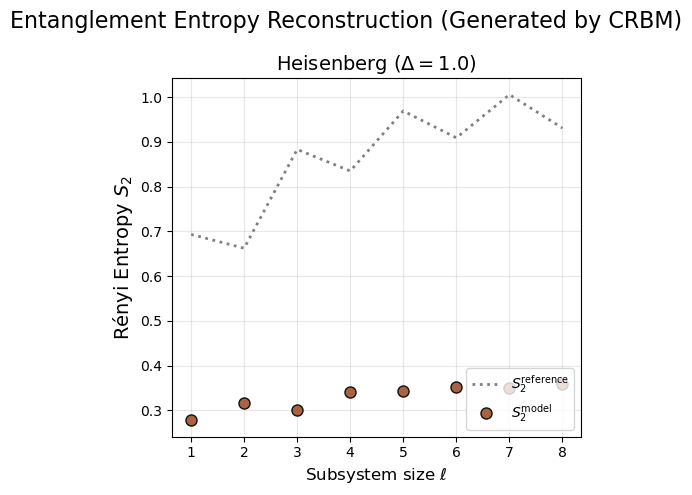

In [16]:
print("\nPlotting...")

# Setup subplots sharing Y axis
fig, axes = plt.subplots(1, len(delta_values), figsize=(5 * len(delta_values), 5),
                         sharey=True, dpi=100)

if len(delta_values) == 1:
    axes = [axes]

styles = {
    0.5: {'color': '#5D8AA8', 'label': r'XY-like ($\Delta=0.5$)'},
    1.0: {'color': '#A0522D', 'label': r'Heisenberg ($\Delta=1.0$)'},
    2.0: {'color': '#556B2F', 'label': r'Néel/Ising ($\Delta=2.0$)'}
}

for i, delta in enumerate(delta_values):
    ax = axes[i]

    # Check if we have data for this delta
    if delta not in results_model:
        ax.set_title(f"$\Delta={delta}$ (No Model Data)")
        continue

    color = styles.get(delta, {'color': 'black', 'label': str(delta)})['color']
    label_txt = styles.get(delta, {'label': str(delta)})['label']

    # --- Reference curve (if exists) ---
    if ref_df is not None:
        mask = np.isclose(ref_df["delta"].values, delta, atol=1e-8)
        if mask.any():
            row = ref_df.loc[mask].iloc[0]
            s2_ref = row[l_cols].to_numpy()

            # Align lengths
            min_len = min(len(l_axis_ref), len(s2_ref))
            ax.plot(l_axis_ref[:min_len], s2_ref[:min_len], ':', color='gray', linewidth=2.0,
                    label=r'$S_2^{\mathrm{reference}}$', zorder=1)

    # --- Model curve ---
    y_data = results_model[delta]
    min_len = min(len(l_axis_ref), len(y_data))

    ax.plot(l_axis_ref[:min_len], y_data[:min_len], 'o', markersize=8, color=color,
            markeredgecolor='black', alpha=0.9,
            label=r'$S_2^{\mathrm{model}}$', zorder=2)

    # Formatting
    ax.set_title(label_txt, fontsize=14)
    ax.set_xlabel(r"Subsystem size $\ell$", fontsize=12)
    ax.set_xticks(l_axis_ref)
    ax.grid(True, alpha=0.3)

    if i == 0:
        ax.set_ylabel(r"Rényi Entropy $S_2$", fontsize=14)
        ax.legend(loc='lower right', fontsize=10)

plt.suptitle(f"Entanglement Entropy Reconstruction (Generated by CRBM)", fontsize=16)
plt.tight_layout()
plt.show()